In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.options.display.float_format = "{:,.4f}".format
pd.set_option('display.max_rows', 400)
pd.set_option('display.max_columns', 400)

In [2]:
import os
import sys
SCRIPT_DIR = os.path.dirname(os.path.abspath(os.getcwd()))
sys.path.append(os.path.dirname(SCRIPT_DIR))
sys.path.append(SCRIPT_DIR)

DATA_DIR = "{}/{}".format(os.getcwd().replace("\\", "/"),"data")

# Load Data

In [3]:
file_names = [
    "spy_eod_202301",
    "spy_eod_202302",
    "spy_eod_202303"
]

file_paths = ["{}/{}.txt".format(DATA_DIR, x) for x in file_names]

In [4]:
df = pd.concat([pd.read_csv(fpath) for fpath in file_paths])

## Cleaning Data

In [5]:
col_names = [x.strip().replace("[", "").replace("]", "").lower() for x in df.columns]
df.columns = col_names

In [7]:
#df['ts'] = np.vectorize(lambda x: pd.to_datetime(x))(df.quote_readtime)
#del df['quote_time_hours']

In [8]:
print(df.shape)
#Keep strikes with distance less than 10% of underlying price and date to expiry as 7 days
df = df[(df.strike_distance_pct < 0.1) & (df.dte.astype(int) == 7)].copy()
df.shape

(245695, 33)


(4603, 33)

In [10]:
df['quote_date'] = np.vectorize(lambda x: x.strip())(df.quote_date)

In [11]:
df['dte_year'] = df.dte/252. #convert dates to expiry from number of days to years. We use 252 since 1 year has approx 252 trading days
df['r'] = 0.05   # Interest rate
df['q'] = 0.015  # Dividend Yield
df['cmid_px'] = 0.5*(df.c_bid + df.c_ask)
df['pmid_px'] = 0.5*(df.p_bid + df.p_ask)

np.array(df[['strike', 'underlying_last', 'dte_year', 'r', 'q', 'cmid_px', 'pmid_px']][0:1])

array([[3.43000000e+02, 3.80820000e+02, 2.77777778e-02, 5.00000000e-02,
        1.50000000e-02, 3.82300000e+01, 3.50000000e-02]])

# Black Scholes

In [10]:
from sde_project.black_scholes import BlackScholesIV

In [12]:
def get_basics(x):
    K = x.strike
    S = x.underlying_last
    T = x.dte/252
    r = 0.0525 # interest rate
    q = 0.0
    mid_px = (x.c_bid + x.c_ask)/2.0
    return K, S, T, r, q, mid_px

def call_bsiv(x):
    #print(x)
    K, S, T, r, q, mid_px = get_basics(x)
    bs = BlackScholesIV(S, K, T, r, q, option_type = 'call')
    try:
        return bs.implied_volatility(mid_px, max_iter=1000)
    except Exception as e:
        #print(x)
        return -1.0

def put_bsiv(x):
    #print(x)
    K, S, T, r, q, mid_px = get_basics(x)
    bs = BlackScholesIV(S, K, T, r, q, option_type = 'put')
    try:
        return bs.implied_volatility(mid_px, max_iter=1000)
    except Exception as e:
        #print(x)
        return -1.0

def call_bspx(x):
    #print(x)
    K, S, T, r, q, mid_px = get_basics(x)
    bs = BlackScholesIV(S, K, T, r, q, option_type = 'call')
    try:
        return bs.implied_volatility(mid_px, max_iter=1000)
    except Exception as e:
        #print(x)
        return -1.0

def put_bspx(x):
    #print(x)
    K, S, T, r, q, mid_px = get_basics(x)
    bs = BlackScholesIV(S, K, T, r, q, option_type = 'put')
    try:
        return bs.implied_volatility(mid_px, max_iter=1000)
    except Exception as e:
        #print(x)
        return -1.0

In [36]:
df['call_iv'] = df.apply(call_bsiv, axis=1)
df['put_iv'] = df.apply(put_bsiv, axis=1)

In [42]:
date = '2023-03-23'
oday = df[df.quote_date == date]

<Axes: xlabel='strike'>

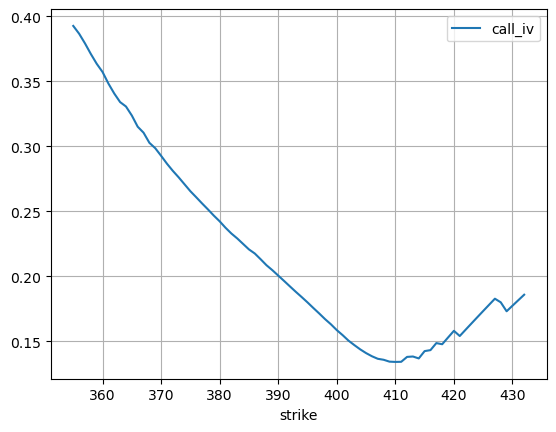

In [43]:
oday[oday.call_iv > 0][['call_iv', 'strike']].set_index('strike').plot(grid=True)

<Axes: xlabel='strike'>

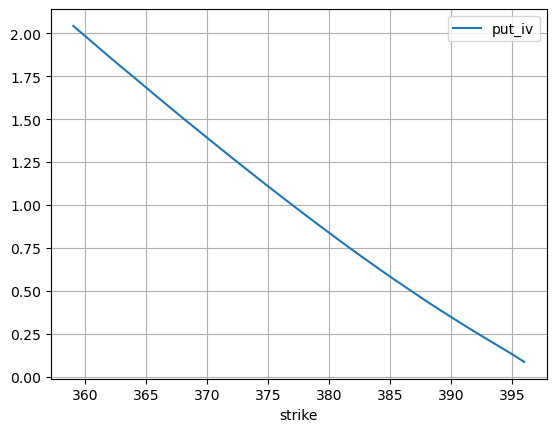

In [44]:
oday[oday.put_iv > 0][['put_iv', 'strike']].set_index('strike').plot(grid=True)

# Heston Model

In [39]:
# Split between insample & outsample

insample  = df[df.quote_date <= '2023-02-28'].copy()
outsample = df[df.quote_date > '2023-02-28'].copy()

In [38]:
from sde_project.calibration_utils import calibrate_heston
from sde_project.heston_model import HestonModel

In [40]:
market_data = np.array(insample[['strike', 'underlying_last', 'dte_year', 'r', 'q', 'cmid_px', 'pmid_px']])

# Initial guess for the parameters: (kappa, theta, sigma, rho, V0)
initial_params = [2.0, 0.02, 0.1, -0.7, 0.02]

# Bounds for each parameter
bounds = [(0.01, 5),   # kappa
          (0.01, 0.5),    # theta
          (0.01, 0.5),    # sigma
          (-0.99, 0.99), # rho
          (0.001, 0.5)]   # V0

heston_model = HestonModel(S0=394.7600, K=356, T=7/252., r=0.05, kappa=2.0, theta=0.02, sigma=0.1, rho=-0.7, V0=0.02)

# Calibrate the model to the market data
optimized_params = calibrate_heston(heston_model, market_data, initial_params, bounds)

print(f"Optimized Heston model parameters: kappa={optimized_params[0]:.4f}, theta={optimized_params[1]:.4f}, "
      f"sigma={optimized_params[2]:.4f}, rho={optimized_params[3]:.4f}, V0={optimized_params[4]:.4f}")

Optimized Heston model parameters: kappa=2.0000, theta=0.0200, sigma=0.1000, rho=-0.7000, V0=0.0200


In [41]:
def get_basics(x):
    K = x.strike
    S = x.underlying_last
    T = x.dte/252
    r = 0.0525 # interest rate
    q = 0.0
    mid_px = (x.c_bid + x.c_ask)/2.0
    return K, S, T, r, q, mid_px

def get_optimized_params():
    kappa, theta, sigma, rho, V0 = tuple(optimized_params)
    return kappa, theta, sigma, rho, V0

def call_hsiv(x):
    #print(x)
    K, S, T, r, q, mid_px = get_basics(x)
    kappa, theta, sigma, rho, V0 = get_optimized_params()
    
    hs = HestonModel(S, K, T, r, kappa, theta, sigma, rho, V0, option_type='call')
    try:
        return hs.implied_volatility(mid_px, max_iter=1000)
    except Exception as e:
        #print(x)
        return -1.0

def put_hsiv(x):
    #print(x)
    K, S, T, r, q, mid_px = get_basics(x)
    kappa, theta, sigma, rho, V0 = get_optimized_params()
    
    hs = HestonModel(S, K, T, r, kappa, theta, sigma, rho, V0, option_type='put')
    try:
        return hs.implied_volatility(mid_px, max_iter=1000)
    except Exception as e:
        #print(x)
        return -1.0

def call_hspx(x):
    #print(x)
    K, S, T, r, q, mid_px = get_basics(x)
    kappa, theta, sigma, rho, V0 = get_optimized_params()
    
    hs = HestonModel(S, K, T, r, kappa, theta, sigma, rho, V0, option_type='call')
    try:
        return hs.option_price()
    except Exception as e:
        #print(x)
        return -1.0

def put_hspx(x):
    #print(x)
    K, S, T, r, q, mid_px = get_basics(x)
    kappa, theta, sigma, rho, V0 = get_optimized_params()
    
    hs = HestonModel(S, K, T, r, kappa, theta, sigma, rho, V0, option_type='put')
    try:
        return hs.option_price()
    except Exception as e:
        #print(x)
        return -1.0

In [42]:
outsample['hs_call_iv'] = outsample.apply(call_hsiv, axis=1)
outsample['hs_put_iv'] = outsample.apply(put_hsiv, axis=1)

outsample['hs_call_px'] = outsample.apply(call_hspx, axis=1)
outsample['hs_put_px'] = outsample.apply(put_hspx, axis=1)

In [46]:
outsample['hs_call_error'] = (outsample['hs_call_px'] - outsample['cmid_px']) **2
outsample['hs_put_error'] = (outsample['hs_put_px'] - outsample['pmid_px']) **2

In [47]:
outsample.filter(regex='hs.*error').describe(percentiles = [.1, .2, .3, .4, .5, .6, .7, .8, .9, .95, .99])

,hs_call_error,hs_put_error
count,"1,670.0000","1,670.0000"
mean,0.2674,1.2074
std,0.6249,2.1136
min,0.0000,0.0000
10%,0.0001,0.0072
20%,0.0004,0.0263
30%,0.0026,0.0662
40%,0.0094,0.1866
50%,0.0293,0.3881
60%,0.0666,0.5543


In [43]:
os_dates = np.sort(outsample.quote_date.unique())

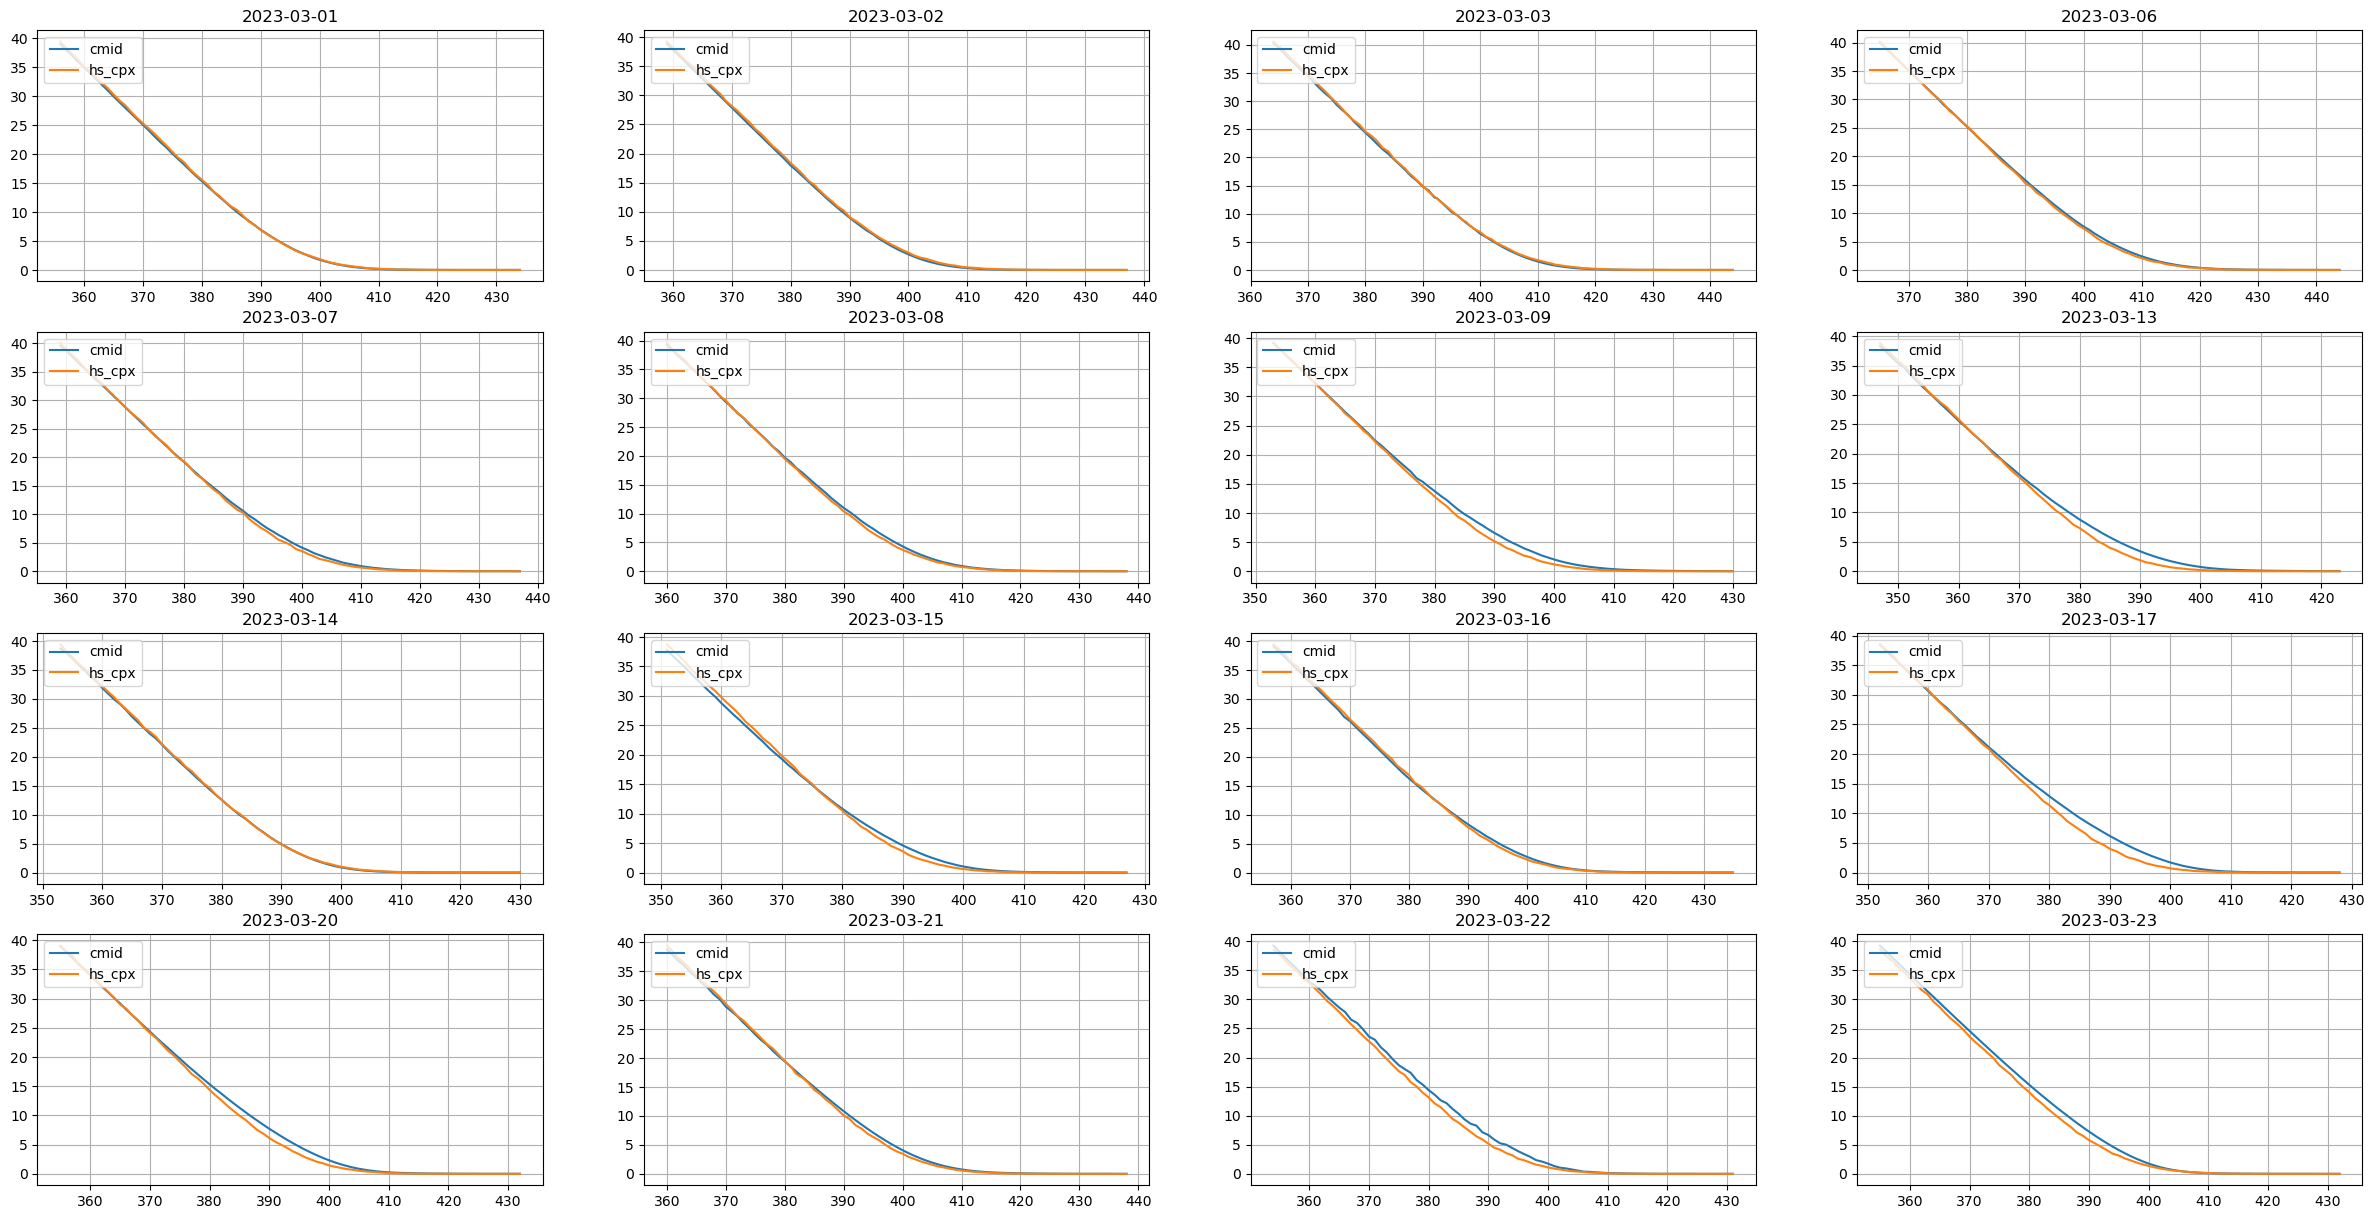

In [44]:
N = 4
fig, ax = plt.subplots(nrows=N, ncols=N)
fig.set_size_inches(30,15)

for i, row in enumerate(ax):
    for j, col in enumerate(row):
        d = os_dates[N*i + j]
        f = outsample.quote_date == d
        #col.plot(outsample[f][['cmid_px', 'hs_call_px', 'strike']].set_index('strike').plot(grid=True, title=d))
        col.plot(outsample[f].strike, outsample[f].cmid_px, label='cmid')
        col.plot(outsample[f].strike, outsample[f].hs_call_px, label='hs_cpx')
        col.legend(loc="upper left")
        col.grid()
        col.set_title(d)

plt.show()

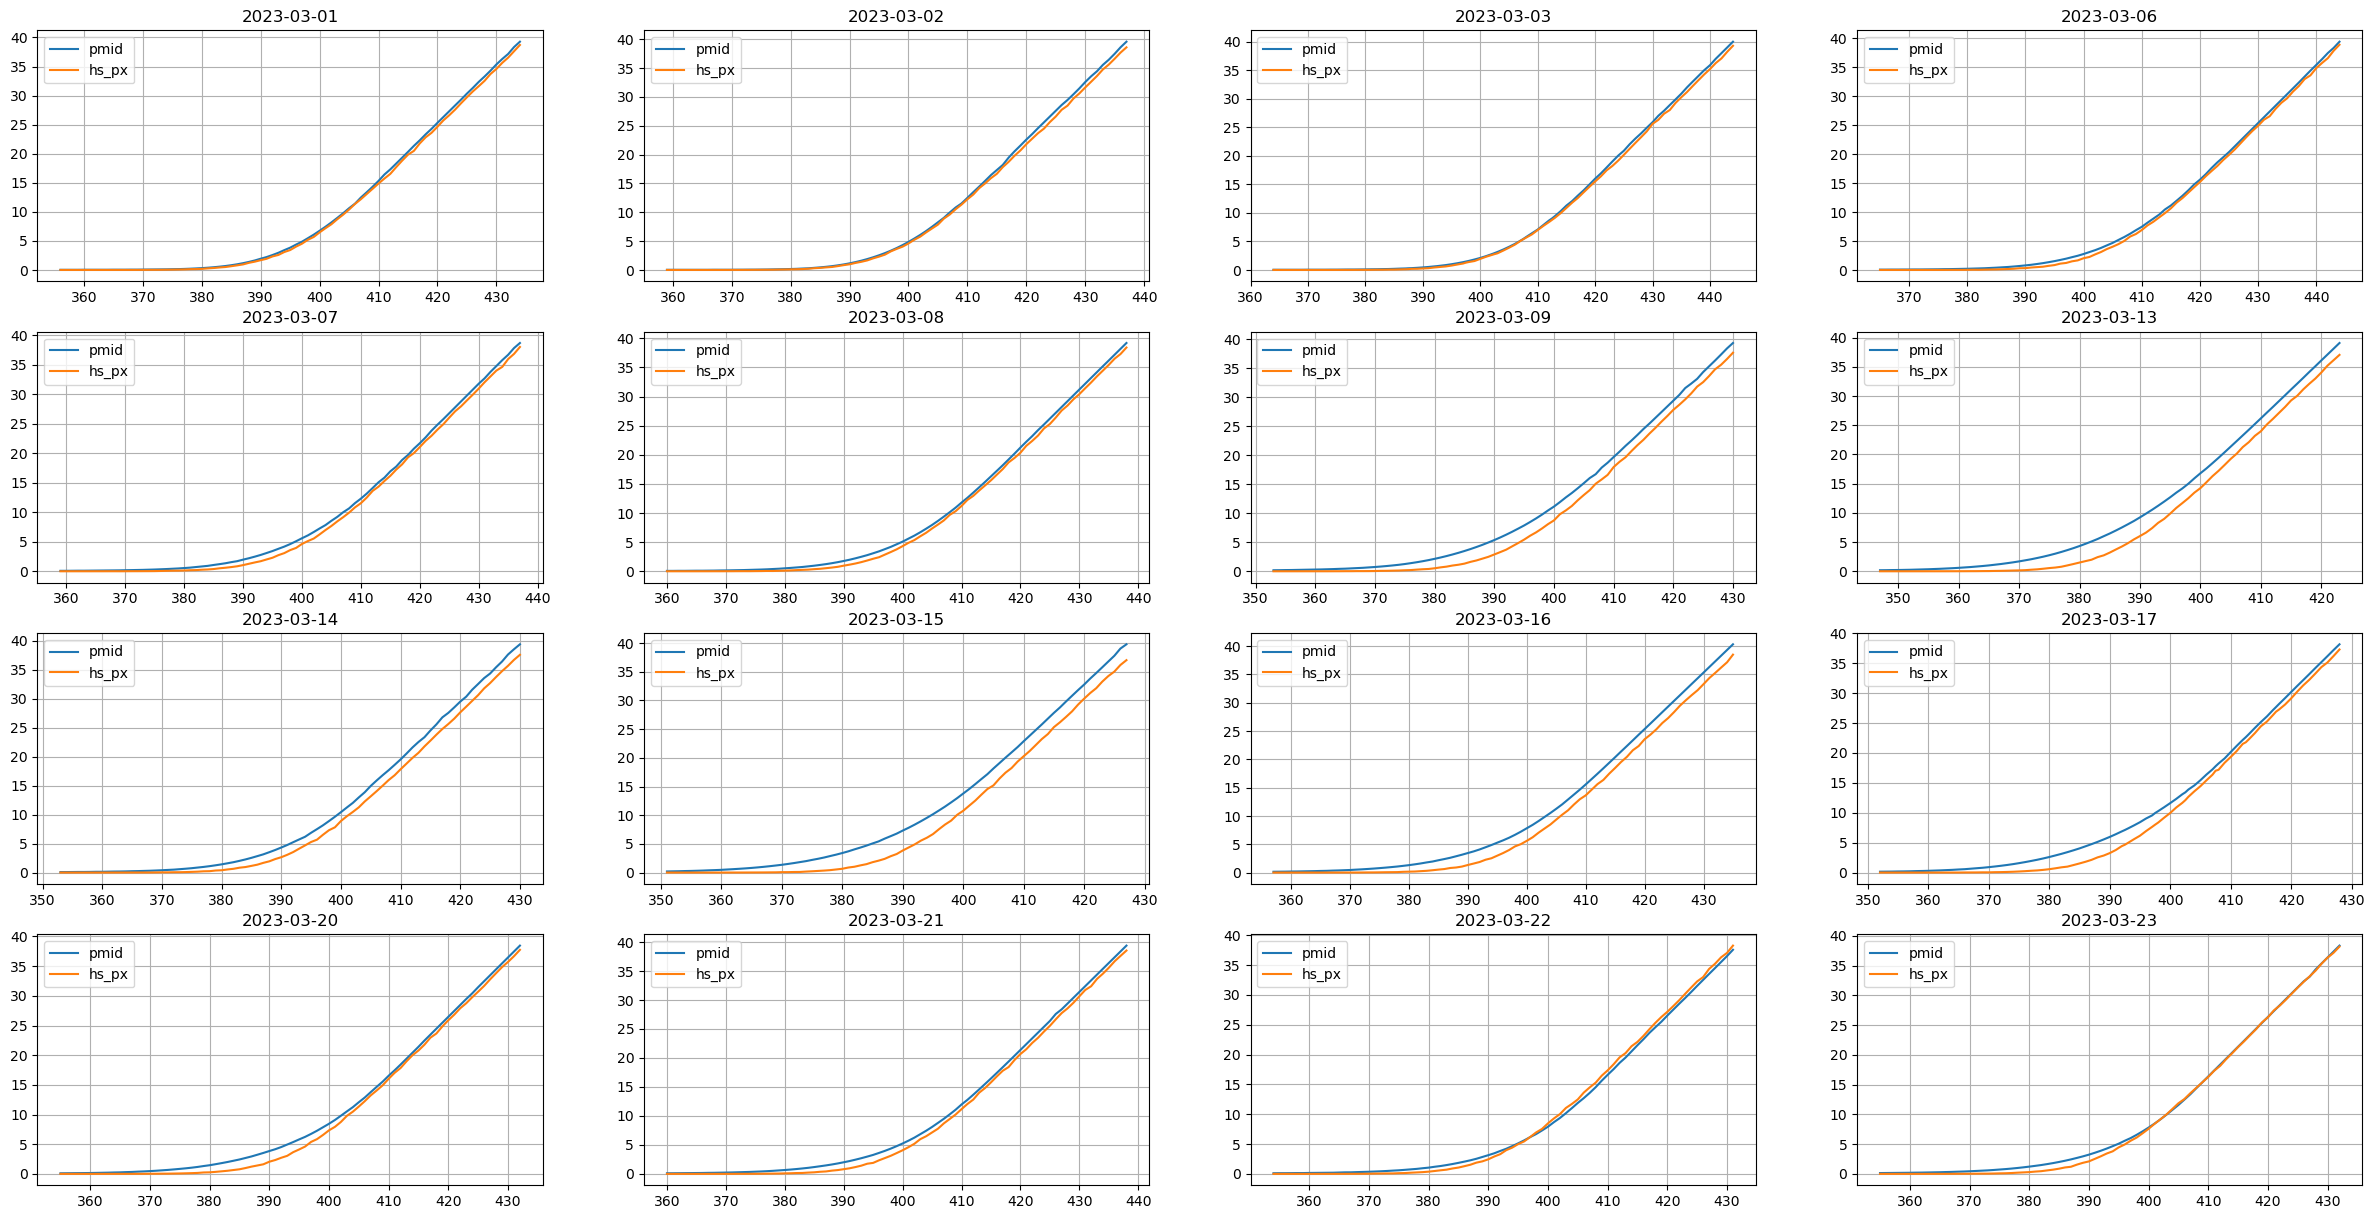

In [45]:
N = 4
fig, ax = plt.subplots(nrows=N, ncols=N)
fig.set_size_inches(30,15)

for i, row in enumerate(ax):
    for j, col in enumerate(row):
        d = os_dates[N*i + j]
        f = outsample.quote_date == d
        #col.plot(outsample[f][['cmid_px', 'hs_call_px', 'strike']].set_index('strike').plot(grid=True, title=d))
        col.plot(outsample[f].strike, outsample[f].pmid_px, label='pmid')
        col.plot(outsample[f].strike, outsample[f].hs_put_px, label='hs_px')
        col.legend(loc="upper left")
        col.grid()
        col.set_title(d)

plt.show()

# SABR Model

In [12]:
from sde_project.sabr_model import SABRModel
from sde_project.calibration_utils import calibrate_sabr

In [13]:
# Split between insample & outsample

insample  = df[df.quote_date <= '2023-02-28'].copy()
outsample = df[df.quote_date > '2023-02-28'].copy()

In [21]:
market_data = np.array(insample[['strike', 'underlying_last', 'dte_year', 'r', 'q', 'cmid_px', 'pmid_px']])

# Initial guess for the parameters: (alpha, beta, rho, nu)
initial_params = [2.0, 0.02, -0.3, 0.4]

# Bounds for each parameter
bounds=[(0.001, None), #alpha
        (0.1, 0.9), #beta
        (-0.999, 0.999), #rho
        (0.001, None)] #nu

sabr_model = SABRModel(F=394.7600, K=356, T=7/252., r=0.052,
                         alpha=initial_params[0],
                         beta=initial_params[1],
                         rho=initial_params[2],
                         nu=initial_params[3],
                        option_type='call')

# Calibrate the model to the market data
s_optimized_params = calibrate_sabr(sabr_model, market_data, initial_params, bounds)

print(f"Optimized SABR model parameters: alpha={optimized_params[0]:.4f}, beta={optimized_params[1]:.4f}, rho={optimized_params[2]:.4f}, nu={optimized_params[3]:.4f}")

Optimized SABR model parameters: alpha=32.2953, beta=0.1000, rho=-0.5334, nu=4.5329


In [31]:
def get_basics(x):
    K = x.strike
    S = x.underlying_last
    T = x.dte/252
    r = 0.0525 # interest rate
    q = 0.0
    mid_px = (x.c_bid + x.c_ask)/2.0
    return K, S, T, r, q, mid_px

def get_optimized_params(s_optimized_params):
    alpha, beta, rho, nu = tuple(s_optimized_params)
    return alpha, beta, rho, nu

def call_sabr_px(x):
    #print(x)
    K, S, T, r, q, mid_px = get_basics(x)
    alpha, beta, rho, nu = get_optimized_params(s_optimized_params)
    
    hs = SABRModel(S, K, T, r, alpha, beta, rho, nu, option_type='call')
    try:
        return hs.option_price()
    except Exception as e:
        print(e)
        return -1.0

def put_sabr_px(x):
    #print(x)
    K, S, T, r, q, mid_px = get_basics(x)
    alpha, beta, rho, nu = get_optimized_params(s_optimized_params)
    
    hs = SABRModel(S, K, T, r, alpha, beta, rho, nu, option_type='put')
    try:
        return hs.option_price()
    except Exception as e:
        #print(x)
        return -1.0

In [32]:
outsample.head(1).apply(call_sabr_px, axis=1)

696   38.8729
dtype: float64

In [33]:
outsample['sabr_call_px'] = outsample.apply(call_sabr_px, axis=1)
outsample['sabr_put_px'] = outsample.apply(put_sabr_px, axis=1)

In [35]:
outsample['sabr_call_error'] = (outsample['sabr_call_px'] - outsample['cmid_px']) **2
outsample['sabr_put_error'] = (outsample['sabr_put_px'] - outsample['pmid_px']) **2

In [36]:
outsample.filter(regex='error').describe(percentiles = [.1, .2, .3, .4, .5, .6, .7, .8, .9, .95, .99])

,sabr_call_error,sabr_put_error
count,"1,670.0000","1,670.0000"
mean,0.2384,0.6087
std,0.5610,1.3275
min,0.0000,0.0000
10%,0.0000,0.0036
20%,0.0002,0.0105
30%,0.0014,0.0214
40%,0.0069,0.0406
50%,0.0204,0.0822
60%,0.0486,0.1399


In [25]:
os_dates = np.sort(outsample.quote_date.unique())

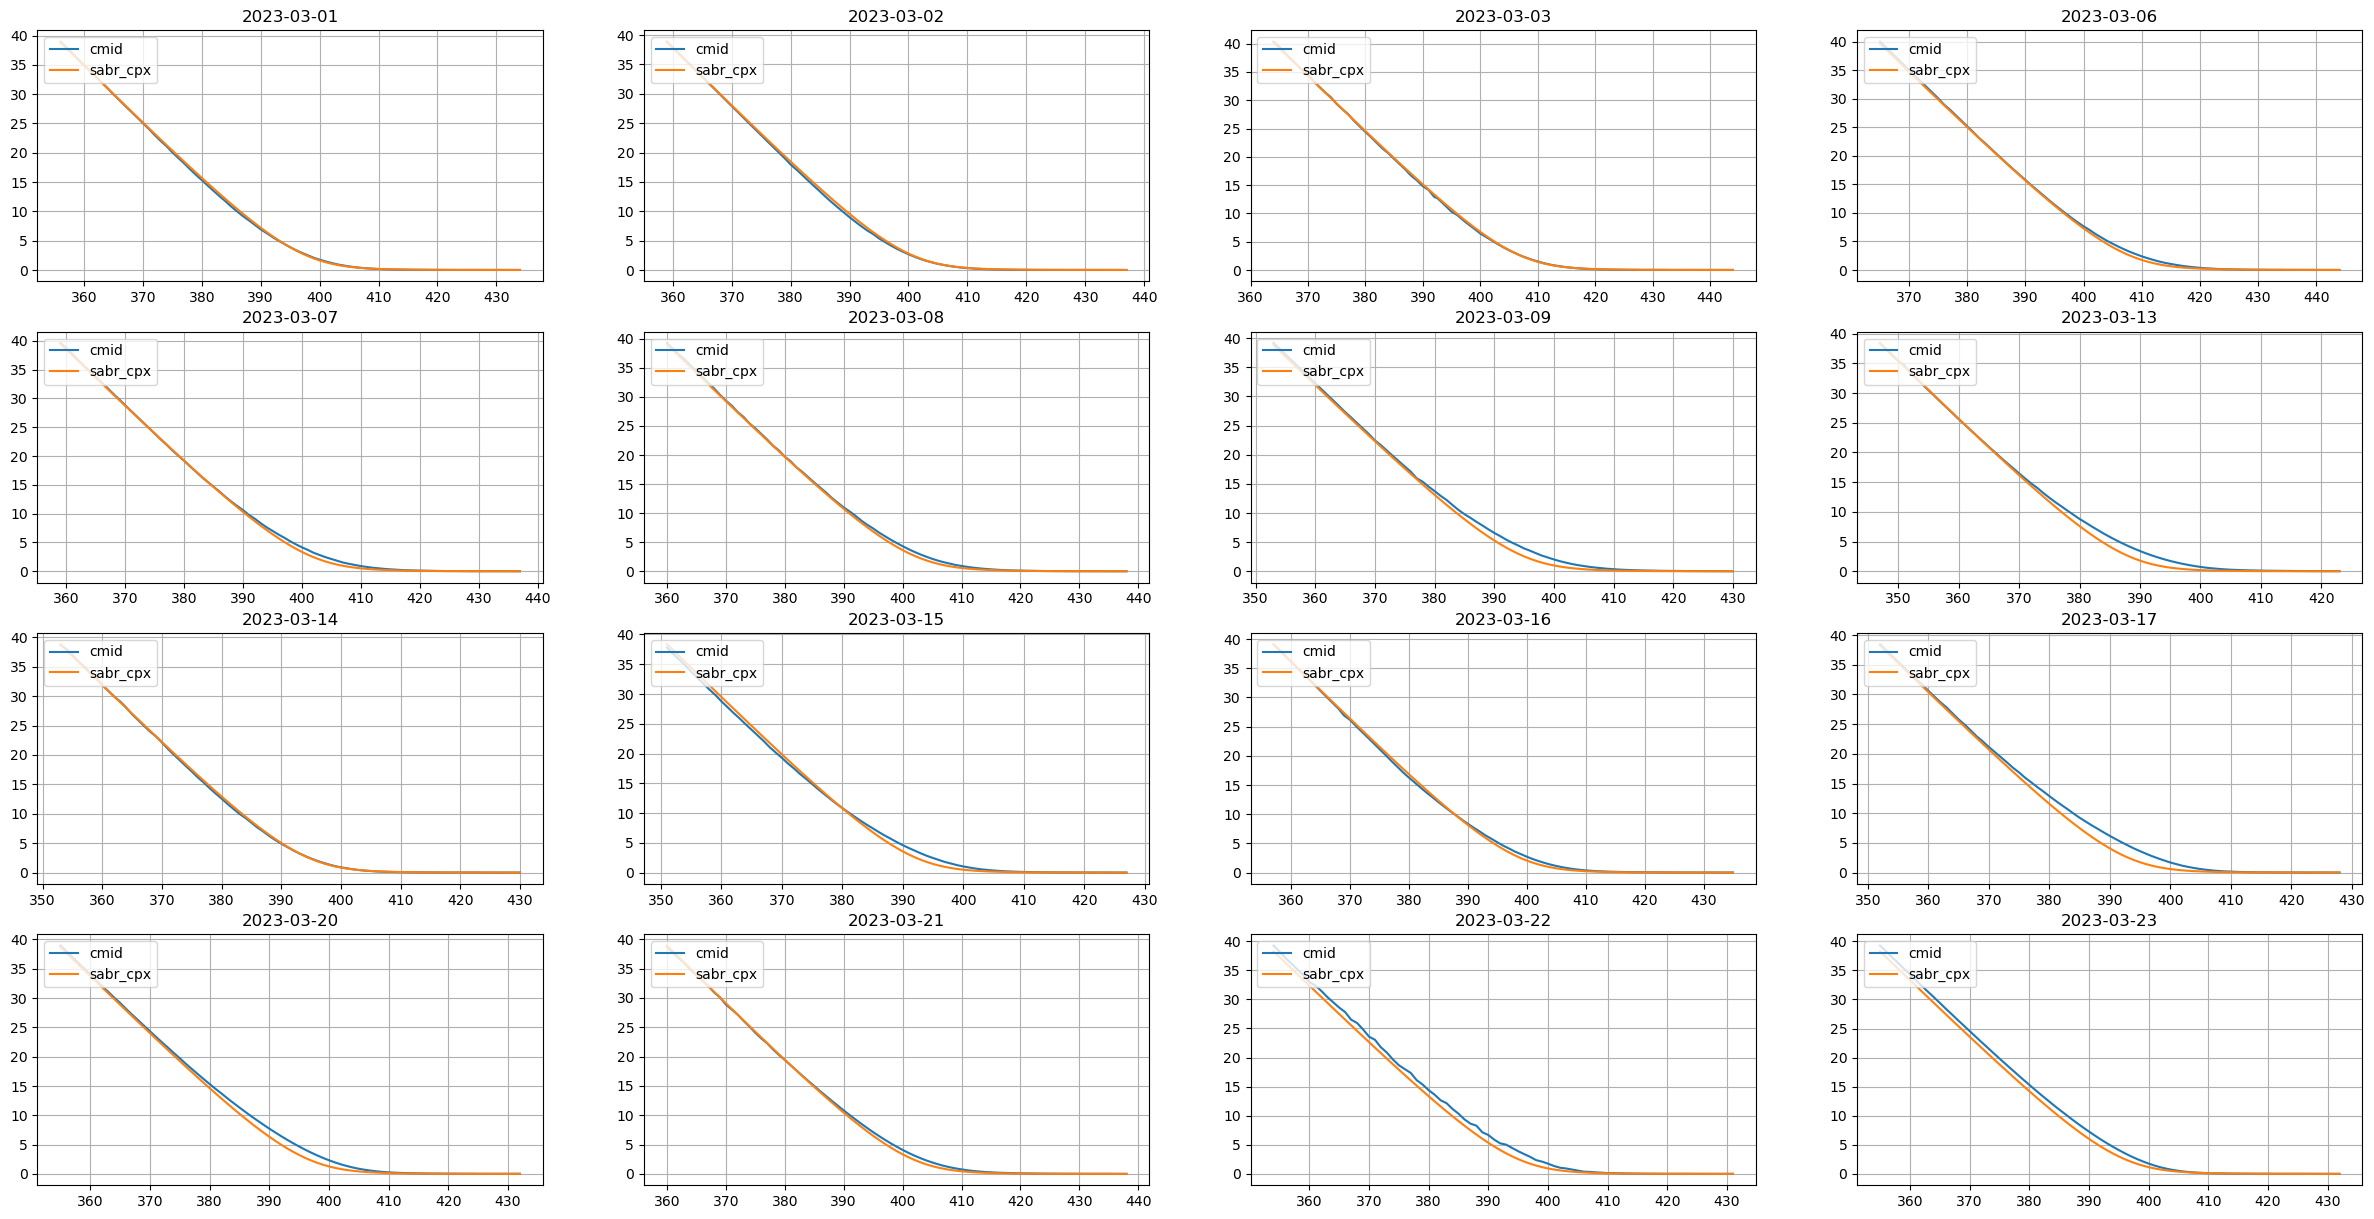

In [26]:
N = 4
fig, ax = plt.subplots(nrows=N, ncols=N)
fig.set_size_inches(30,15)

for i, row in enumerate(ax):
    for j, col in enumerate(row):
        d = os_dates[N*i + j]
        f = outsample.quote_date == d
        #col.plot(outsample[f][['cmid_px', 'hs_call_px', 'strike']].set_index('strike').plot(grid=True, title=d))
        col.plot(outsample[f].strike, outsample[f].cmid_px, label='cmid')
        col.plot(outsample[f].strike, outsample[f].sabr_call_px, label='sabr_cpx')
        col.legend(loc="upper left")
        col.grid()
        col.set_title(d)

plt.show()

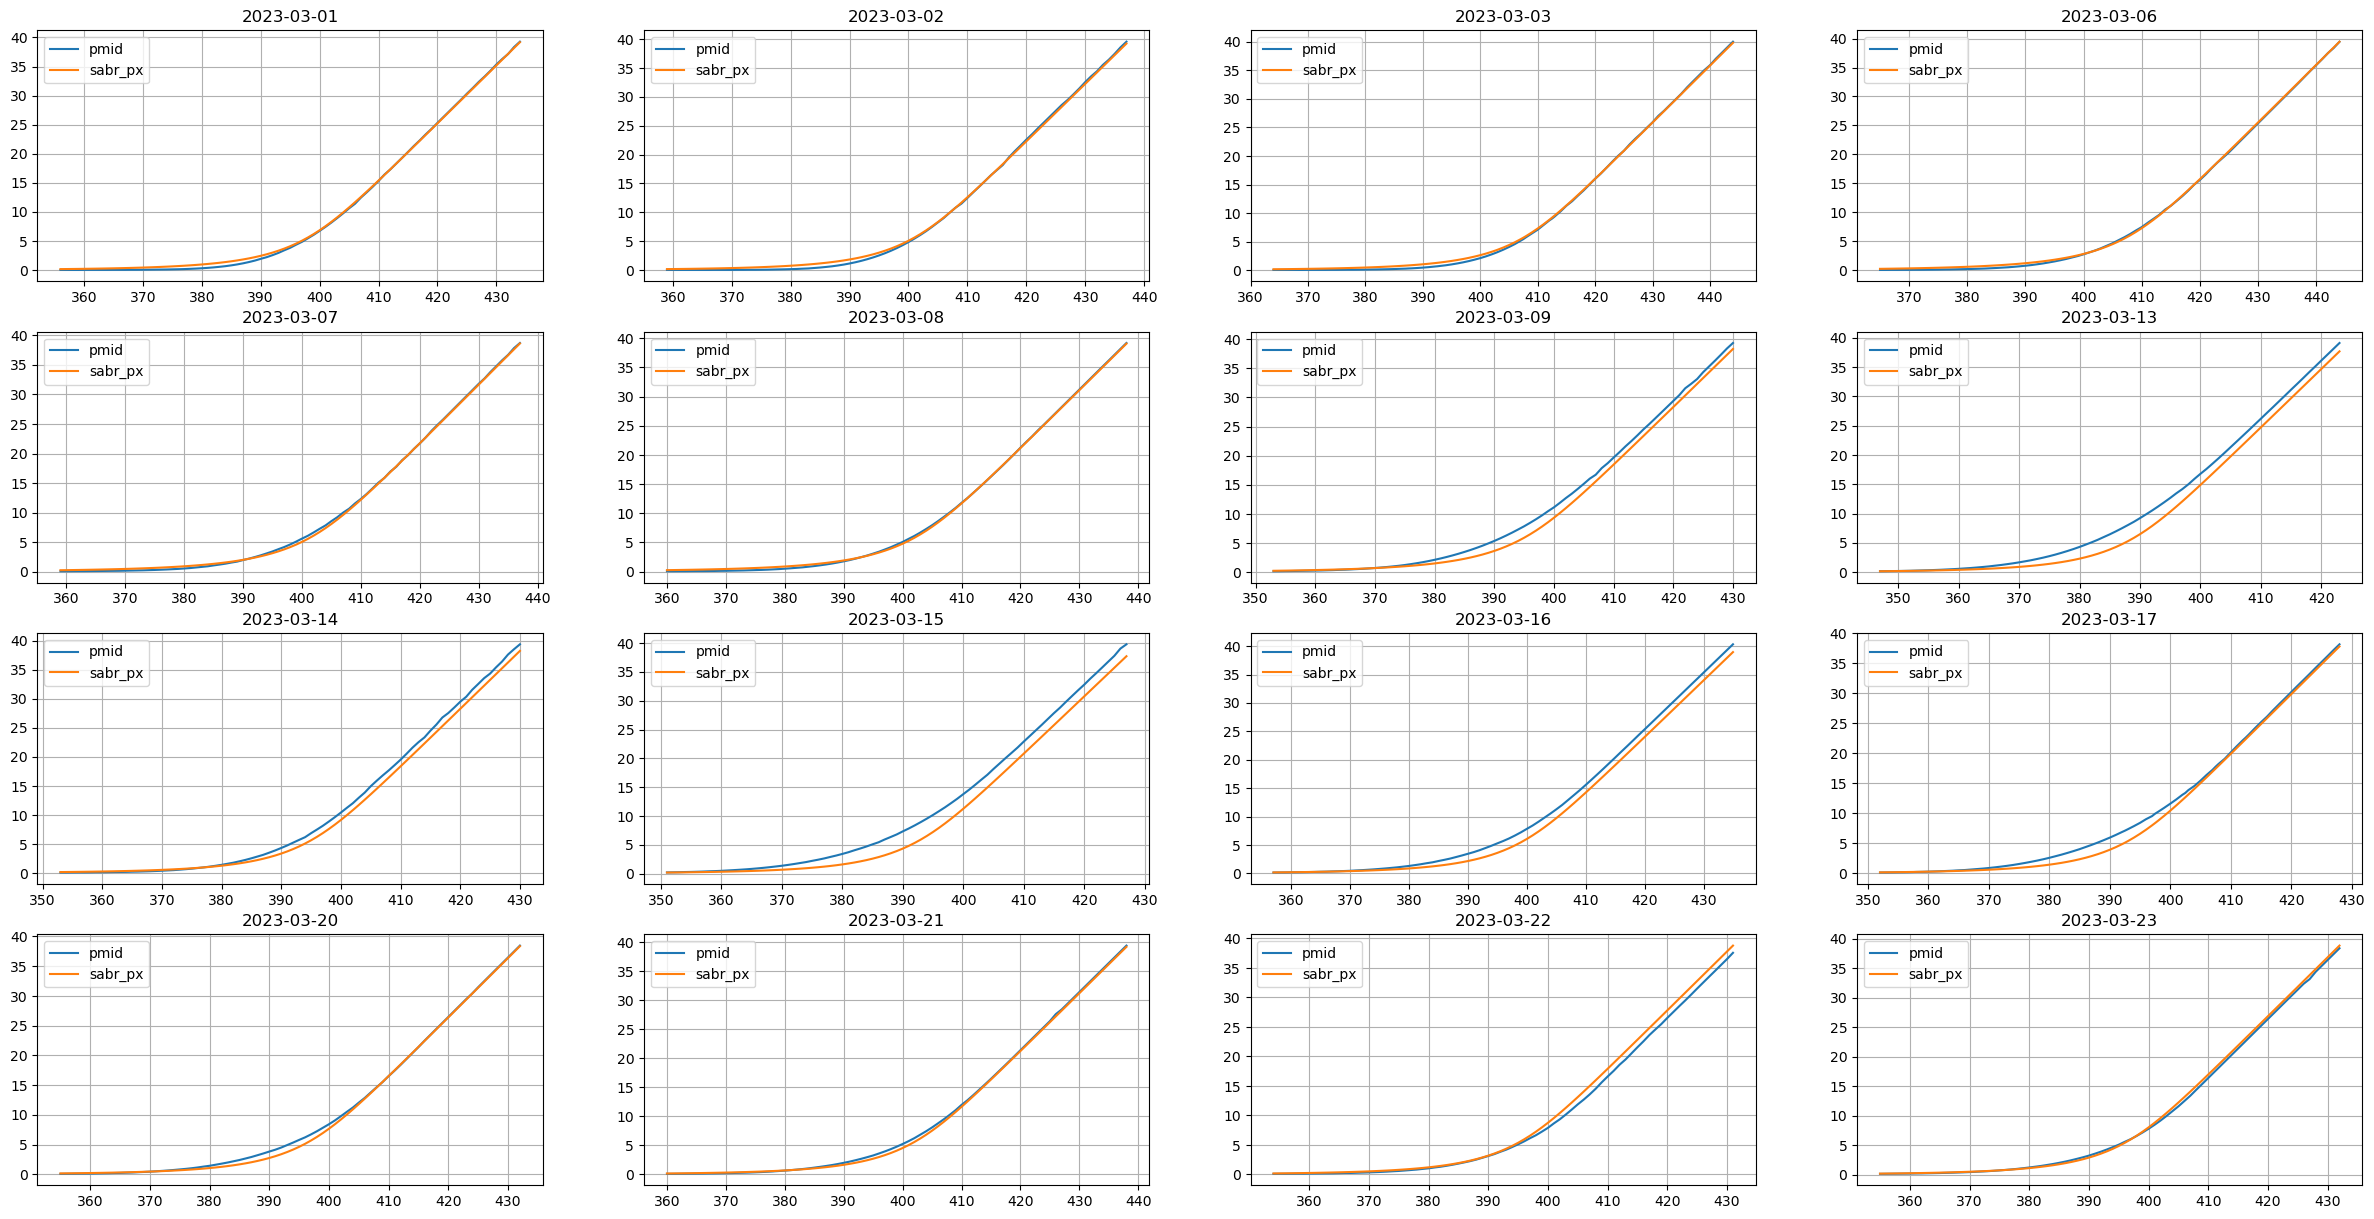

In [27]:
N = 4
fig, ax = plt.subplots(nrows=N, ncols=N)
fig.set_size_inches(30,15)

for i, row in enumerate(ax):
    for j, col in enumerate(row):
        d = os_dates[N*i + j]
        f = outsample.quote_date == d
        #col.plot(outsample[f][['cmid_px', 'hs_call_px', 'strike']].set_index('strike').plot(grid=True, title=d))
        col.plot(outsample[f].strike, outsample[f].pmid_px, label='pmid')
        col.plot(outsample[f].strike, outsample[f].sabr_put_px, label='sabr_px')
        col.legend(loc="upper left")
        col.grid()
        col.set_title(d)

plt.show()